[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreofner/pyGPC/blob/master/demo.ipynb)

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


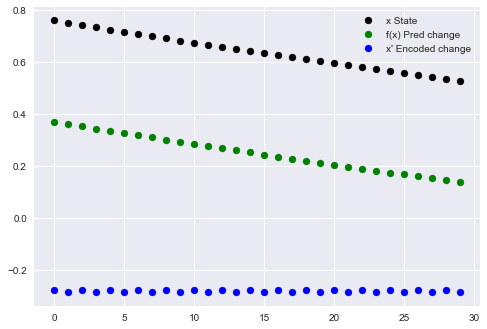

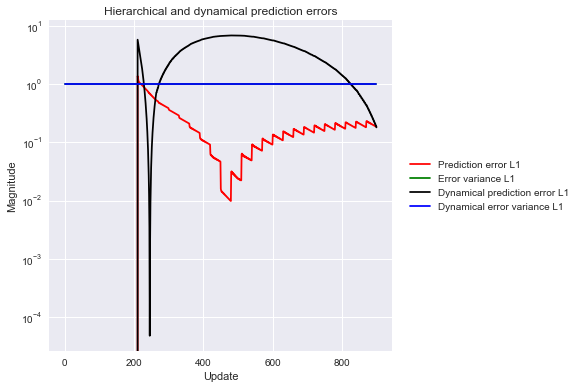

In [4]:
"""
Dynamical generalized predictive coding on circles dataset

A simple demonstration (two layer model with a single hidden unit)
- learning generalized coordinates from discrete sensory data
- hierarchical prediction in generalized coordinates:
        - predicting state coordinates from a higher layer
        - couples latent states to lower causes (or sensory inputs)
- hierarchical prediction in generalized coordinates:
        - training hidden states to predict their own motion
        - this couples orders of latent state dynamics
"""

import matplotlib.pyplot as plt
import torch
import math
import numpy as np
import IPython
import MovingMNIST as MovingMNIST
from model_circles import *
from circles_dataset import *

train_set = torch.from_numpy(get_dataset(get_dataset_args())['x']).transpose(0,1)

# hierarchical net
GEN_COORDS = 3
cause_sizes = [1, 0]
hidden_sizes = [0, 1]
net = GPC_net(b_size=BATCH_SIZE, dynamical_net=False,
              cause_sizes=cause_sizes, hidden_sizes=hidden_sizes,
              gen_coords=GEN_COORDS)

# logging and visualization
errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
err_h1, err_h2, err_h3 = [], [], []
colors, lines = ["black", "yellow", "orange", "red", "brown", "purple"], []

INTERPOLATE = False
INTERPOLATION_START = 30
INTERPOLATION_END = INTERPOLATION_START + GEN_COORDS-1
INTERPOLATION_EPOCH = 0
FINAL_EPOCH = 1

for epoch in range(FINAL_EPOCH):
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=BATCH_SIZE, shuffle=False)
    for seq_id, seq in enumerate(train_loader):
        vid_in, vid_p1, vid_p2, vid_p3, vid_p4 = [], [], [], [], []
        vid_gc_cause, vid_gc_hidden = [], []
        vid_cause_coords, vid_gc_pred, vid_cause_coords_input = [], [], []

        seq = torch.transpose(seq, 0,1)
        if seq_id == INTERPOLATION_EPOCH and epoch == FINAL_EPOCH-1:
            INTERPOLATE = True
        for id, data in enumerate(seq):
            data = data/2

            if True:
                data = data[:,:1]

            VIDEO = False
            if (id < INTERPOLATION_START): # optimize
                for update in range(UPDATES):

                    # step hierarchical net
                    if id > GEN_COORDS * 2: # give the sensory layer some time to adjust at the start
                        # step dynamical nets
                        eg1, eh1, ed1, cg1, cd1 = net.layers[1].dyn_model.iterative_inference(updates=1, predict_hierarchical=False)
                        e, _, _, ch, _ = net.iterative_inference(data, updates=1)

                        # plot inference updates
                        if True and id == INTERPOLATION_START-1:
                            state = net.layers[1].dyn_model.layers[0].states.hidd_state.detach()
                            pred_change = net.layers[1].dyn_model.nets_d[0](state).detach()
                            encoded_change = net.layers[1].dyn_model.layers[1].states.hidd_state.detach()
                            l1 = plt.scatter(update, state[0,0], color="black", label="x State", alpha=(epoch+1)/FINAL_EPOCH)
                            l2 = plt.scatter(update, pred_change[0,0], color="green", label="f(x) Pred change", alpha=(epoch+1)/FINAL_EPOCH)
                            l3 = plt.scatter(update, encoded_change[0,0], color="blue", label="x' Encoded change", alpha=(epoch+1)/FINAL_EPOCH)

                    else:
                        eg1, eh1, ed1, cg1, cd1 = [0.], [0.], [0.], [1.], [1.]
                        e, ch = [[0.]], [[1.]]

                    errors, cov_h = errors + e, cov_h + ch
                    errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
                    err_g1, cov_g1 = err_g1 + eg1, cov_g1 + cg1
                    err_h1 = err_h1+eh1;

                # step dynamical nets
                _, _, _, _, _ = net.layers[0].dyn_model.iterative_inference(data, updates=10)

                # log encoded inputs in generalized coordinates
                cause_coords = [l.states.cause_state.detach().numpy()[...,0,:] for l in net.layers[0].dyn_model.layers]
                vid_cause_coords_input.append(np.asarray(cause_coords))

                for layer in net.layers:
                    layer.dyn_model.state_diff(step=True) # move current to previous state

                VIDEO = True
            elif INTERPOLATE:
                """Visualize generalized coordinates / encoded local trajectory"""
                # extrapolate encoded input in gen. coordinates
                time = id-INTERPOLATION_START+1
                cause_coords = net.layers[0].dyn_model.decode_dynamical_cause(t=time)
                vid_cause_coords.append(cause_coords)

                """Visualize dynamical prediction / motion of predicted local trajectory"""
                # predict and overwrite hidden state dynamics
                if True:
                    #net.layers[1].dyn_model.decode_dynamical_prediction()
                    # decode the predicted state motion # todo t
                    net.layers[1].dyn_model.decode_dynamical_hidden(t=time)

                VIDEO = True

            # create video
            if VIDEO:
                input, preds = plot_2D(net=net, img_size=IMG_SIZE, plot=False)
                input = data.detach()[0]
                vid_in.append(input.detach().numpy().reshape([IMG_SIZE]))
                vid_p1.append(preds[0][0][0].reshape([IMG_SIZE])) # 1st predicted gen coord
                vid_p2.append(preds[0][1][0].reshape([IMG_SIZE])) # 2nd predicted gen coord
                vid_p3.append(preds[0][2][0].reshape([IMG_SIZE])) # 3rd predicted gen coord

                state_coords = net.layers[0].dyn_model.layers[1].lower.states.cause_state[0].detach().numpy()
                hidd_coords = net.layers[0].dyn_model.layers[1].lower.states.hidd_state[0].detach().numpy()
                vid_gc_cause.append(state_coords)
                vid_gc_hidden.append(hidd_coords)

            if id == INTERPOLATION_END: break
        if seq_id == INTERPOLATION_EPOCH: break

plt.legend(handles=[l1,l2,l3])
plt.show()

""" Losses """
if True:
    plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
               cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h,
               hierarchical=True, g_coords=False, dynamical=True)


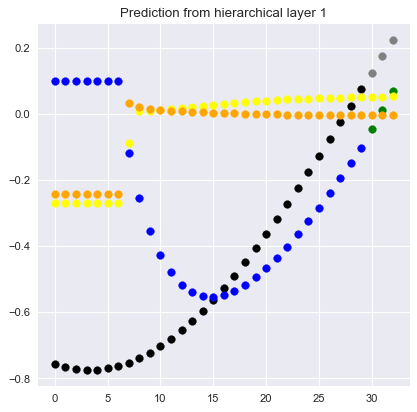

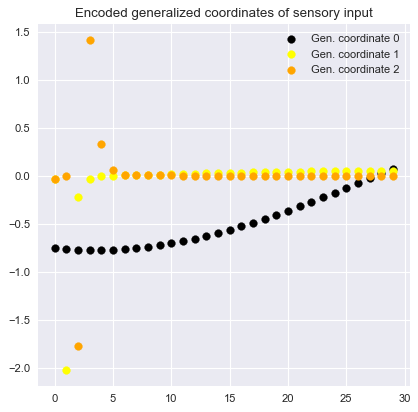

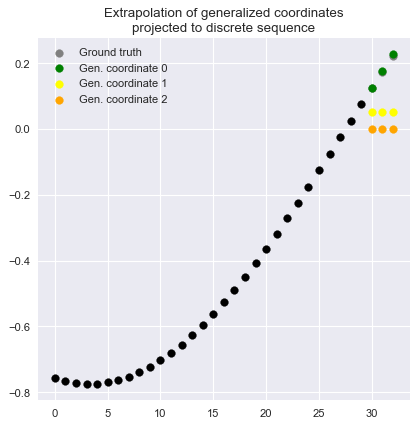

Note that we have to wait a bit until the sensory layer has enough context to correctly encoded the discrete sequence in generalized coordinates


In [5]:
""" Hierarchical predictions """
# plot settings
GC_TIME = False # align higher order generalized coordinates to a time axis

plt.figure(figsize=(6, 6), dpi=80)
for t, (inp, pred, pred1, pred2) in enumerate(zip(vid_in, vid_p1, vid_p2, vid_p3)):
    colors, lines = ["green", "yellow", "orange", "red", "brown", "purple"], []
    if GC_TIME:
        pred[0] = pred1[0] = pred2[0] = inp[0]
    if t < INTERPOLATION_START:
        plt.scatter(t, inp[0], color="black")
        plt.scatter(t, pred[0], color="blue")
        plt.scatter(t, pred1[0], color=colors[1])
        plt.scatter(t, pred2[0], color=colors[2])
    else:
        plt.scatter(t, inp[0], color="grey")
        plt.scatter(t, pred[0], color="green")
        plt.scatter(t, pred1[0], color=colors[1])
        plt.scatter(t, pred2[0], color=colors[2])
plt.title("Prediction from hierarchical layer 1")
plt.show()


""" Encoded generalized coordinates of input """
plt.figure(figsize=(6, 6), dpi=80)
for t, inp in enumerate(vid_cause_coords_input):
    colors, lines = ["black", "yellow", "orange", "red", "brown", "purple"], []
    for gc in range(len(vid_cause_coords_input[t])):
        select = 0 if GC_TIME else gc
        lines.append(plt.scatter(t, # vid_cause_coords_input[t][select][0]
                    vid_cause_coords_input[t][gc][0], color=colors[gc], label=f"Gen. coordinate {gc}"))
plt.title("Encoded generalized coordinates of sensory input")
plt.legend(handles=lines)
plt.show()

""" Extrapolated encoded generalized coordinates of input """
plt.figure(figsize=(6, 6), dpi=80)
for t, inp in enumerate(vid_in):
    if t < INTERPOLATION_START:
        l0 = plt.scatter(t, inp[0], color="black", label="Ground truth (burn in)")
    else:
        colors, lines = ["green", "yellow", "orange", "red", "brown", "purple"], []
        lines.append(plt.scatter(t, inp[0], color="grey", label="Ground truth"))
        for gc in range(len(vid_cause_coords[t-INTERPOLATION_START])):
            select = 0 if GC_TIME else gc
            lines.append(plt.scatter(t, #vid_cause_coords[t-INTERPOLATION_START][select][0]
                        vid_cause_coords[t-INTERPOLATION_START][gc][0],
                        color=colors[gc], label=f"Gen. coordinate {gc}"))
plt.title("Extrapolation of generalized coordinates\nprojected to discrete sequence")
plt.legend(handles=lines)
#plt.ylim(-1,1), plt.xlim(-1,1)
plt.show()

print("Note that we have to wait a bit until the sensory layer has enough context to correctly encoded the discrete sequence in generalized coordinates")

